In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Load and resize image
def load_image(filepath: str) -> np.ndarray:
    im: Image.Image = Image.open(filepath)
    (width, height) = (im.width // 4, im.height // 4)
    im_resized = im.resize((width, height))
    return np.array(im_resized)

im = load_image('img200.png')
print('Dimensions: ', im.shape)

Dimensions:  (256, 320, 3)


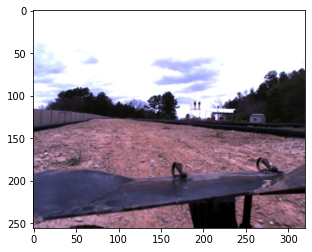

In [3]:
plt.imshow(im)
plt.show()

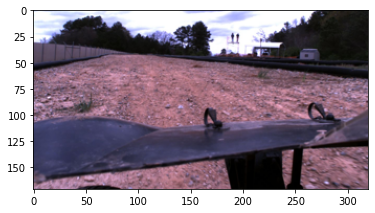

In [4]:
# From the other images, it seems like the road is mainly in the two-thirds of the image. Let's just crop it to that.
im_crop = im[im.shape[0] // 3:, :]
plt.imshow(im_crop)
plt.show()

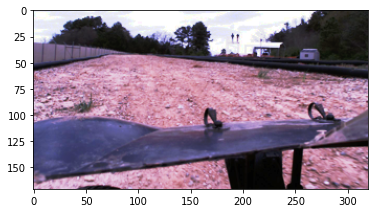

In [5]:
# Use histogram equalization to increase the image's contrast
from skimage import exposure
im_eq = exposure.equalize_hist(im_crop)
plt.imshow(im_eq)
plt.show()

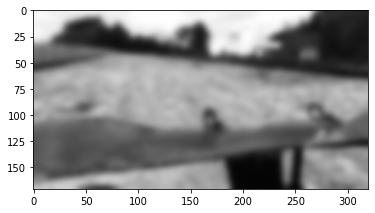

In [6]:
# Blur the image to make the road look more even
from scipy.ndimage import gaussian_filter
im_blur = gaussian_filter(im_eq, sigma=3)
plt.imshow(im_blur)
plt.show()

In [7]:
# Reshape the image into NxD array
im_flat = im_blur.reshape(-1, 3)
print('Shape of flattened image:', im_flat.shape)

Shape of flattened image: (54720, 3)


In [8]:
# This paper suggests choosing epsilon based on the distance of the 3rd nearest neighbor
# https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdfhttps://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3).fit(im_flat)
distances, indices = nbrs.kneighbors(im_flat)
distances = distances[:, 2]
distances = np.sort(distances, axis=0)
eps = distances[-3]
print('Suggested epsilon value:', eps)

Suggested epsilon value: 0.0009985360200951959


In [9]:
# Use OPTICS clustering algorithm
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=eps, min_samples=40).fit(im_flat)
labels = clustering.labels_

In [10]:
unique_labels = np.unique(labels)
print('Number of unique labels:', len(unique_labels))
print('Labels:', unique_labels)

Number of unique labels: 52
Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50]


In [11]:
counts = []
for label in unique_labels:
    counts.append(len(labels[labels == label]))
ind_max = np.argmax(counts)
print('Total labels', len(unique_labels))
print(unique_labels[ind_max], counts[ind_max])
max_label = unique_labels[ind_max]


Total labels 52
5 19293


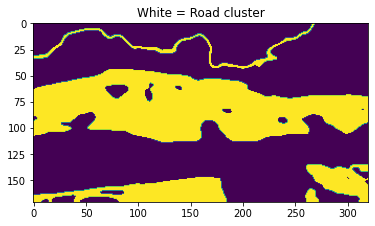

In [12]:
im_clustered = np.zeros(im_flat.shape[0], dtype='float64')
im_clustered[labels == max_label] = 1
im_clustered = im_clustered.reshape(im_blur.shape[:2])
plt.imshow(im_clustered)
plt.title('White = Road cluster')
plt.show()

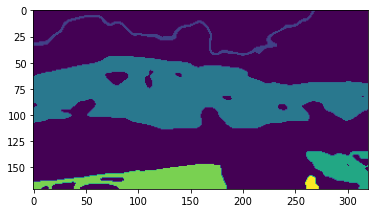

In [13]:
# Find the connected components
from skimage import measure
all_labels = measure.label(im_clustered, background=0)
plt.imshow(all_labels)

[35427, 907, 14392, 1311, 2562, 121]


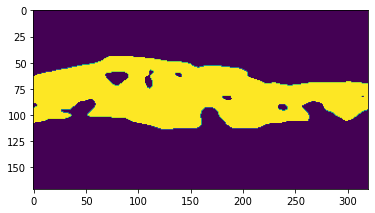

In [14]:
def get_largest_label(labels: np.ndarray) -> int:
    uniques = np.unique(labels)
    sizes = []
    for u in uniques:
        sizes.append(len(labels[labels==u]))
    print(sizes)
    size = np.sort(sizes)[-2]
    ind_max = np.argwhere(sizes == size)
    return uniques[ind_max].reshape(-1)[0]

largest_label = get_largest_label(all_labels)
mask = np.zeros(all_labels.shape)
mask[all_labels == largest_label] = 1
plt.imshow(mask)
plt.show()

171


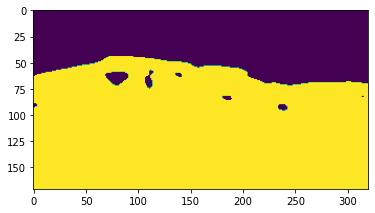

In [15]:
# Assume the road fills from the bottom of the image
from skimage.segmentation import flood_fill
print(mask.shape[0])
mask = flood_fill(mask, (mask.shape[0] - 1, 0), 1)
plt.imshow(mask)
plt.show()

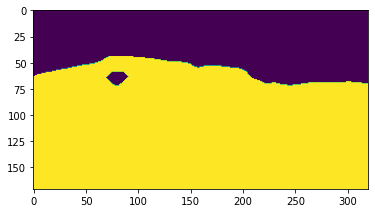

In [16]:
from skimage.morphology import binary_closing
#https://stackoverflow.com/questions/58348401/numpy-array-filled-in-diamond-shape
def diamond(n):
    a = np.arange(n)
    b = np.minimum(a,a[::-1])
    return ((b[:,None]+b)>=(n-1)//2).astype(np.int)
kernel = diamond(9)
closed = binary_closing(mask, kernel)
plt.imshow(closed)
plt.show()

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.ndimage import gaussian_filter
from skimage import measure
from skimage.segmentation import flood_fill
from skimage.morphology import binary_closing

class RoadDetection:
    def __init__(self, im: np.ndarray):
        self.im = im
        self.processed_im = self.__preprocess(im)
        self.road_mask = self.__segment_road(self.processed_im)
    
    def __preprocess(self, im: np.ndarray) -> np.ndarray:
        # Crop
        im_crop = im[im.shape[0] // 3:, :]

        # Use histogram equalization to increase the image's contrast
        im_eq = exposure.equalize_hist(im_crop)

        # Blur the image to make the road look more even
        im_blur = gaussian_filter(im_eq, sigma=3)
        return im_blur

    def __get_largest_label(self, labels: np.ndarray) -> int:
        uniques = np.unique(labels)
        sizes = []
        for u in uniques:
            sizes.append(len(labels[labels==u]))
        size = np.sort(sizes)[-2]
        ind_max = np.argwhere(sizes == size)
        print(uniques, sizes, size)
        return uniques[ind_max].reshape(-1)[0]

    def __diamond(self, n):
        a = np.arange(n)
        b = np.minimum(a,a[::-1])
        return ((b[:,None]+b)>=(n-1)//2).astype(np.int)
    
    def __segment_road(self, im: np.ndarray) -> np.ndarray:
        # Reshape the image into NxD array
        im_flat = im.reshape(-1, 3)
        # This paper suggests choosing epsilon based on the distance of the 3rd nearest neighbor
        # https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdfhttps://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
        nbrs = NearestNeighbors(n_neighbors=3).fit(im_flat)
        distances, indices = nbrs.kneighbors(im_flat)
        distances = distances[:, 2]
        distances = np.sort(distances, axis=0)
        eps = distances[-3]

        # Use DBSCAN clustering algorithm
        clustering = DBSCAN(eps=eps, min_samples=40).fit(im_flat)
        labels = clustering.labels_

        # Find the label with the highest count
        unique_labels = np.unique(labels)
        counts = []
        for label in unique_labels:
            counts.append(len(labels[labels == label]))
        ind_max = np.argmax(counts)
        max_label = unique_labels[ind_max]

        im_clustered = np.zeros(im_flat.shape[0], dtype='float64')
        im_clustered[labels == max_label] = 1
        im_clustered = im_clustered.reshape(self.processed_im.shape[:2])

        # Find the connected components
        all_labels = measure.label(im_clustered, background=0)

        # Find the largest connected component and make a road mask
        largest_label = self.__get_largest_label(all_labels)
        mask = np.zeros(all_labels.shape)
        mask[all_labels == largest_label] = 1

        # Assume the road fills from the bottom of the image
        # for c in range(mask.shape[1]):
        #     r = mask.shape[0] - 1
        #     if mask[r, c] == 0:
        #         mask = flood_fill(mask, (r, c), 1)
        # mask = flood_fill(mask, (mask.shape[0] - 1, 0), 1)

        # Use binary closing to fill in small gaps on the road
        kernel = self.__diamond(15)
        closed = binary_closing(mask, kernel)
        return closed

In [66]:
# Load and resize image
def load_image(filepath: str) -> np.ndarray:
    im: Image.Image = Image.open(filepath)
    (width, height) = (im.width // 4, im.height // 4)
    im_resized = im.resize((width, height))
    return np.array(im_resized)

im = load_image('images/img3504.png')
im_RoadData = RoadDetection(im)

[0 1 2] [36727, 5928, 12065] 12065


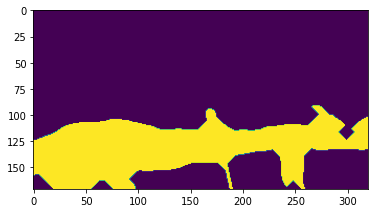

In [67]:
plt.imshow(im_RoadData.road_mask)

In [40]:
import glob
from tqdm import tqdm

image_names = glob.glob('images/img*.png')
image_mats = []
road_data = []

for image in tqdm(image_names):
    im = load_image(image)
    image_mats.append(im)
    im_RoadData = RoadDetection(im)
    road_data.append(im_RoadData)



100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


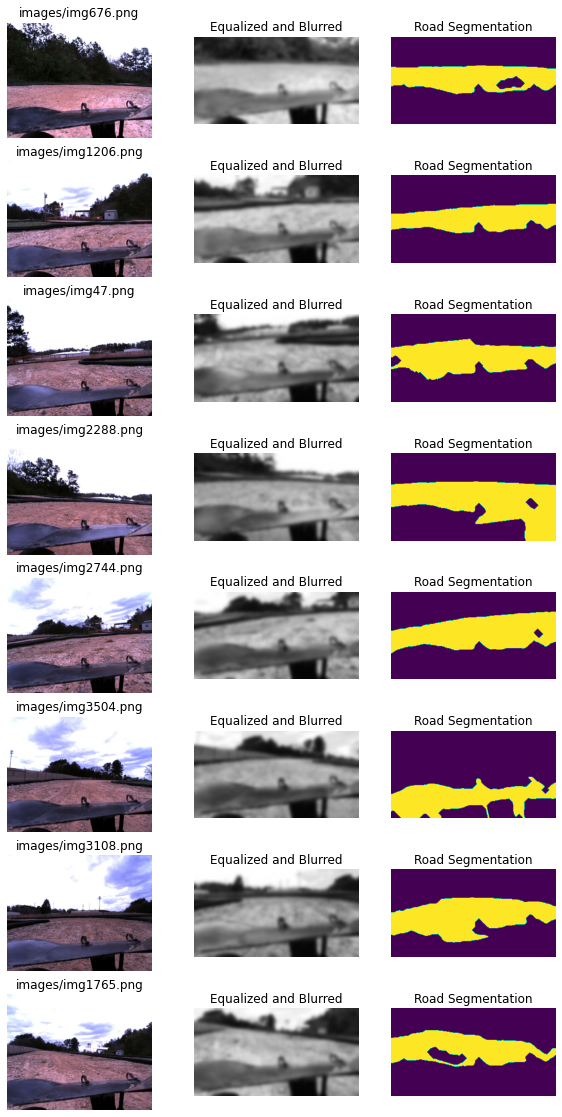

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(image_names), 3, figsize=(20, 10))
fig.set_figheight(20)
fig.set_figwidth(10)
for r in range(len(image_names)):
    ax[r, 0].set_title(images[r])
    ax[r, 0].imshow(image_mats[r])
    ax[r, 0].axis('off')
    ax[r, 1].set_title('Equalized and Blurred')
    ax[r, 1].imshow(road_data[r].processed_im)
    ax[r, 1].axis('off')
    ax[r, 2].set_title('Road Segmentation')
    ax[r, 2].imshow(road_data[r].road_mask)
    ax[r, 2].axis('off')

plt.show()